# Sparse Monge displacements

This tutorial illustrates the potential of using mixed costs of the form 
$$
c(x, y) = h_\tau(x - y)\text{ with } h_\tau(z) = \frac12\|z\|^2_2 + \tau(z)
$$
where $\tau$ is a structure-inducing cost, for instance a $\ell_1$ norm to induce sparsity.
When looking at the estimated entropic Monge maps, such cost induces sparsity of the displacements: only a few coordinates of samples from the source distribution change to match the target distribution.
This idea is introduced in {cite}`cuturi:23`

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

We illustrate the problem in a 2d setting:

In [3]:
n_source = 30
n_target = 50
n_test = 10
p = 2

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)
x = jax.random.normal(keys[0], (n_source, p))

y0 = jax.random.normal(keys[1], (n_target // 2, p)) + jnp.array([5, 0])
y1 = jax.random.normal(keys[2], (n_target // 2, p)) + jnp.array([0, 8])
y = jnp.concatenate([y0, y1])

In [4]:
# Plotting utility
def plot_map(x, y, x_new=None, z=None):
    plt.figure(figsize=(10, 8))
    label = r"$T_{x\rightarrow y}(x)$"

    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    if z is not None:
        plt.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        plt.scatter(*z.T, s=150, edgecolors="k", marker="X", label=label)
        plt.scatter(*x_new.T, s=150, edgecolors="k", marker="o", label=label)
    plt.legend(fontsize=22)

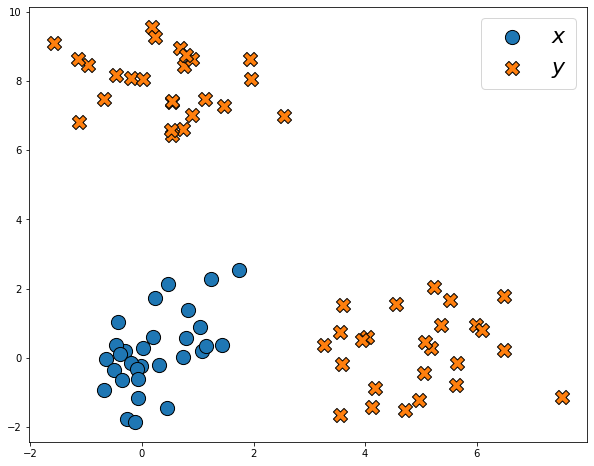

In [5]:
plot_map(x, y)

We also draw some fresh unseen samples from the source distribution:

In [6]:
n_new = 10

x_new = jax.random.normal(keys[3], (n_new, p))

First, let us compute the "standard" entropic map between these two distributions using the $\ell_2^2$ cost, following {cite}`pooladian:21`: we compute the solution of Sinkhorn on the problem, and then use the estimated parameters to compute the dual potentials.

In [7]:
solver = jax.jit(sinkhorn.Sinkhorn())

In [8]:
geom = pointcloud.PointCloud(x, y, cost_fn=costs.SqEuclidean())
output = solver(linear_problem.LinearProblem(geom))
dual_potentials = output.to_dual_potentials()

The dual potentials can then be used to build the entropic map with the `transport` function:

In [9]:
transported = dual_potentials.transport(x_new)

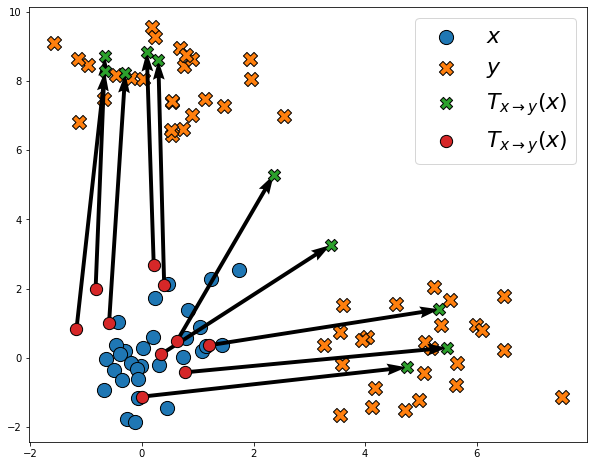

In [10]:
plot_map(x, y, x_new, transported)

We see that the displacements have no particular structure. We now turn to mixed costs, with the `costs.ElasticL1` cost that corresponds to the function 
$$
h_\tau(z) = \frac12\|z\|_2^2 + \gamma \|z\|_1.
$$

In [11]:
geom = pointcloud.PointCloud(x, y, cost_fn=costs.ElasticL1(gamma=10))
output = solver(linear_problem.LinearProblem(geom))
dual_potentials = output.to_dual_potentials()
transported = dual_potentials.transport(x_new)

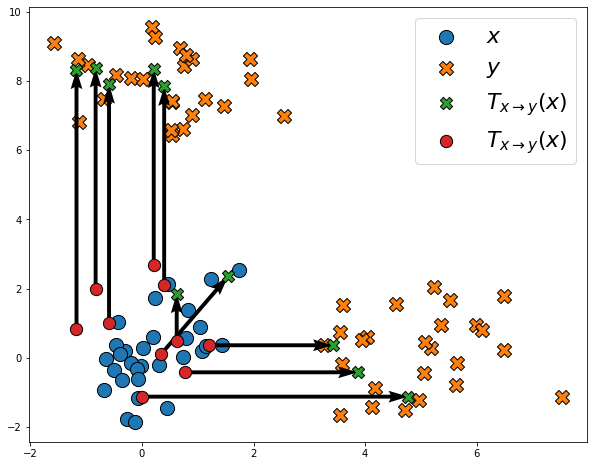

In [12]:
plot_map(x, y, x_new, transported)

We now see that most samples are transported in a sparse way: for most samples, only one coordinate is changed. Importantly, it is not the same coordinate for each sample: some samples move along the two directions, while some other samples move only along the x- or the y- axis.